In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-transport-statistics/mta_1708.csv
/kaggle/input/new-york-city-transport-statistics/mta_1706.csv
/kaggle/input/new-york-city-transport-statistics/mta_1712.csv
/kaggle/input/new-york-city-transport-statistics/mta_1710.csv


In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv(
    "/kaggle/input/new-york-city-transport-statistics/mta_1706.csv", 
    usecols = [
    "RecordedAtTime", "DirectionRef", "PublishedLineName", "OriginName", "OriginLat", "OriginLong",
    "DestinationName", "DestinationLat", "DestinationLong", "VehicleRef",
    "VehicleLocation.Latitude", "VehicleLocation.Longitude", "NextStopPointName",
    "ArrivalProximityText", "DistanceFromStop", "ExpectedArrivalTime", "ScheduledArrivalTime"
])

/tmp/ipykernel_36/4001976423.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [5]:
# filter out buses at-stop

df = df[df['ArrivalProximityText']!='at stop']
df = df.reset_index(drop=True)

In [6]:
# filter out buses at-stop

df = df[df['ArrivalProximityText']!='at stop']
df = df.reset_index(drop=True)

In [7]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,24:06:14
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02
2,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,24:03:00
3,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,40.792897,-73.950023,MADISON AV/E 106 ST,approaching,73.0,2017-06-01 00:03:56,24:02:35
4,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,40.648801,-73.882682,PENNSYLVANIA AV/DELMAR LOOP N,< 1 stop away,196.0,2017-06-01 00:04:13,23:58:47


In [9]:
def get_time_diff(time1, time2):
    if not pd.notna(time1):
        return np.nan
    if not pd.notna(time2):
        return np.nan
    time1 = time1.split(':')
    lst1 = list(map(int, time1))
    h1 = lst1[0]
    m1 = lst1[1]
    s1 = lst1[2]
    seconds1 = h1*3600 + m1*60 + s1
    time2 = time2.split(':')
    lst2 = list(map(int, time2))
    h2 = lst2[0]
    m2 = lst2[1]
    s2 = lst2[2]
    seconds2 = h2*3600 + m2*60 + s2
    one_side_diff = abs(seconds2-seconds1)
    other_side_diff = 24*3600 - one_side_diff
    return min(one_side_diff, other_side_diff)

def ExpectedArrivalTime_extract_time(time):
    if not pd.notna(time):
        return np.nan
    time = time.strip()
    time = time.split(' ')[-1]
    time = time.split(':')
    if len(time) != 3:
        return np.nan
    lst = list(map(int, time))
    h = lst[0]
    m = lst[1]
    s = lst[2]
    return str(h).zfill(2) + ':' + str(m).zfill(2) + ':' + str(s).zfill(2)

def fix_ScheduledArrivalTime(time):
    if not pd.notna(time):
        return np.nan
    time = time.strip()
    time = time.split(' ')[-1]
    time = time.split(':')
    lst = list(map(int, time))
    h = lst[0] if lst[0]<24 else lst[0]-24
    m = lst[1]
    s = lst[2]
    return str(h).zfill(2) + ':' + str(m).zfill(2) + ':' + str(s).zfill(2)

In [10]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,24:06:14
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02
2,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,24:03:00
3,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,40.792897,-73.950023,MADISON AV/E 106 ST,approaching,73.0,2017-06-01 00:03:56,24:02:35
4,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,40.648801,-73.882682,PENNSYLVANIA AV/DELMAR LOOP N,< 1 stop away,196.0,2017-06-01 00:04:13,23:58:47


In [11]:
from tqdm import tqdm

tqdm.pandas()

In [12]:
df['fixed_ScheduledArrivalTime'] = df['ScheduledArrivalTime'].progress_apply(fix_ScheduledArrivalTime)

100%|██████████| 4830962/4830962 [00:12<00:00, 374327.83it/s]


In [13]:
df['extracted_ExpectedArrivalTime'] = df['ExpectedArrivalTime'].progress_apply(ExpectedArrivalTime_extract_time)

100%|██████████| 4830962/4830962 [00:12<00:00, 391649.30it/s]


In [14]:
df['time_diff'] = df.progress_apply(lambda x: get_time_diff(x['fixed_ScheduledArrivalTime'], x['extracted_ExpectedArrivalTime']), axis=1)

100%|██████████| 4830962/4830962 [00:56<00:00, 85780.71it/s] 


In [15]:
def is_delay(time1, time2, time_diff):
    if not pd.notna(time1):
        return np.nan
    if not pd.notna(time2):
        return np.nan
    time2compare = pd.to_timedelta(time1) + pd.Timedelta(seconds=time_diff)
    if time2compare > pd.Timedelta(days=1):
        time2compare = time2compare - pd.Timedelta(days=1)
    if time2compare == pd.to_timedelta(time2):
        return True
    return False

df['is_delay'] = df.progress_apply(lambda x: is_delay(x['fixed_ScheduledArrivalTime'], x['extracted_ExpectedArrivalTime'], x['time_diff']), axis=1)

100%|██████████| 4830962/4830962 [03:02<00:00, 26517.79it/s]


In [16]:
df_delay_vis = df[['PublishedLineName', 'time_diff']][df['is_delay']==True]
df_delay_vis = df_delay_vis.groupby(['PublishedLineName']).mean()
df_delay_vis['average_delay'] = df_delay_vis['time_diff'].mean()

df_mismatch_vis = df[['PublishedLineName', 'time_diff']][df['is_delay']==False]
df_mismatch_vis = df_mismatch_vis.groupby(['PublishedLineName']).mean()
df_mismatch_vis['average_mismatch'] = df_mismatch_vis['time_diff'].mean()

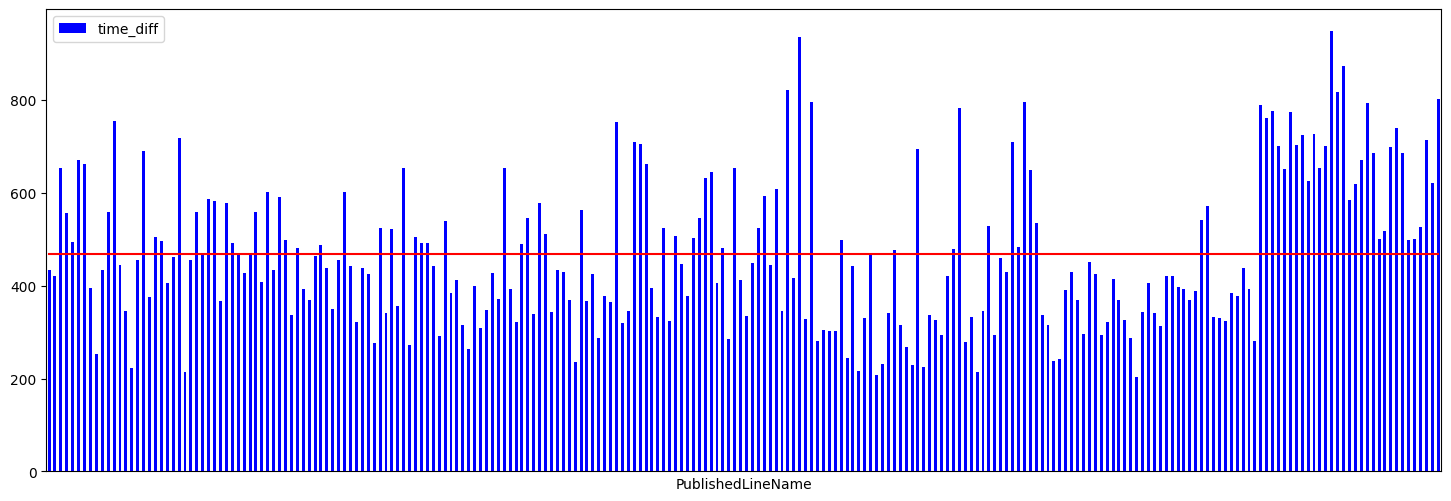

In [17]:
from matplotlib import pyplot as plt
df_delay_vis.plot(y='time_diff', kind='bar', color='blue', figsize=[18, 6])
plt.plot(df_delay_vis['average_delay'].values, color='red')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

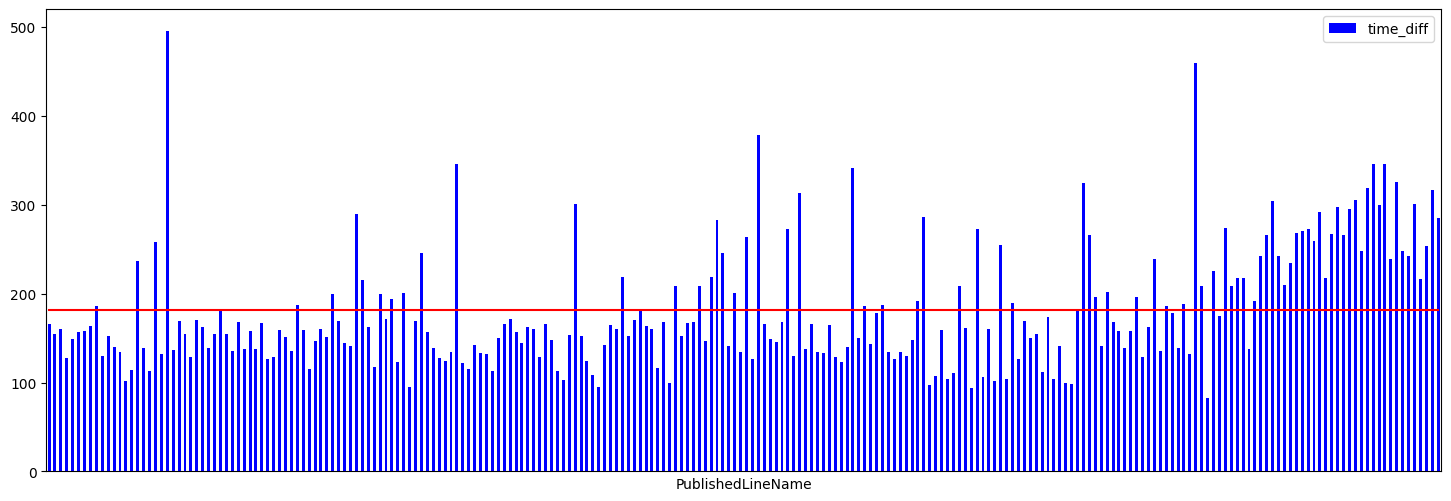

In [18]:
df_mismatch_vis.plot(y='time_diff', kind='bar', color='blue', figsize=[18, 6])
plt.plot(df_mismatch_vis['average_mismatch'].values, color='red')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [19]:
# Print the actual overall average delay (seconds) for delayed samples
print("Actual overall average delay (seconds):", df_delay_vis['average_delay'].iloc[0])

# If you want it in minutes:
print("Actual overall average delay (minutes):", df_delay_vis['average_delay'].iloc[0] / 60)

# If you want the overall mismatch average too:
print("Actual overall average mismatch (seconds):", df_mismatch_vis['average_mismatch'].iloc[0])
print("Actual overall average mismatch (minutes):", df_mismatch_vis['average_mismatch'].iloc[0] / 60)


Actual overall average delay (seconds): 468.7518161711343
Actual overall average delay (minutes): 7.812530269518905
Actual overall average mismatch (seconds): 181.296278694151
Actual overall average mismatch (minutes): 3.0216046449025167


In [21]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,fixed_ScheduledArrivalTime,extracted_ExpectedArrivalTime,time_diff,is_delay
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,24:06:14,00:06:14,00:03:59,135.0,False
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02,23:58:02,00:03:56,354.0,True
2,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,24:03:00,00:03:00,00:04:03,63.0,True
3,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,...,-73.950023,MADISON AV/E 106 ST,approaching,73.0,2017-06-01 00:03:56,24:02:35,00:02:35,00:03:56,81.0,True
4,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,...,-73.882682,PENNSYLVANIA AV/DELMAR LOOP N,< 1 stop away,196.0,2017-06-01 00:04:13,23:58:47,23:58:47,00:04:13,326.0,True


In [23]:
# Remove rows with any null values
df = df.dropna()

In [24]:
# Convert to datetime format with error handling
df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'], errors='coerce')
df['ExpectedArrivalTime'] = pd.to_datetime(df['ExpectedArrivalTime'], errors='coerce')

# Check for any rows where the conversion failed
invalid_times = df[df['ExpectedArrivalTime'].isna()]
print("Rows with invalid ExpectedArrivalTime:")
print(invalid_times)

Rows with invalid ExpectedArrivalTime:
Empty DataFrame
Columns: [RecordedAtTime, DirectionRef, PublishedLineName, OriginName, OriginLat, OriginLong, DestinationName, DestinationLat, DestinationLong, VehicleRef, VehicleLocation.Latitude, VehicleLocation.Longitude, NextStopPointName, ArrivalProximityText, DistanceFromStop, ExpectedArrivalTime, ScheduledArrivalTime, fixed_ScheduledArrivalTime, extracted_ExpectedArrivalTime, time_diff, is_delay]
Index: []

[0 rows x 21 columns]


In [25]:
# Extract features from RecordedAtTime
df['RecordedHour'] = df['RecordedAtTime'].dt.hour
df['RecordedMinute'] = df['RecordedAtTime'].dt.minute
df['RecordedSecond'] = df['RecordedAtTime'].dt.second
df['RecordedDayOfWeek'] = df['RecordedAtTime'].dt.dayofweek

df.head()


,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ExpectedArrivalTime,ScheduledArrivalTime,fixed_ScheduledArrivalTime,extracted_ExpectedArrivalTime,time_diff,is_delay,RecordedHour,RecordedMinute,RecordedSecond,RecordedDayOfWeek
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,2017-06-01 00:03:59,24:06:14,00:06:14,00:03:59,135.0,False,0,3,34,3
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,2017-06-01 00:03:56,23:58:02,23:58:02,00:03:56,354.0,True,0,3,43,3
2,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,2017-06-01 00:04:03,24:03:00,00:03:00,00:04:03,63.0,True,0,3,31,3
3,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,...,2017-06-01 00:03:56,24:02:35,00:02:35,00:03:56,81.0,True,0,3,40,3
4,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,...,2017-06-01 00:04:13,23:58:47,23:58:47,00:04:13,326.0,True,0,3,29,3


In [26]:
df['trip_time'] = (df['ExpectedArrivalTime'] - df['RecordedAtTime']).dt.total_seconds()

In [27]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,fixed_ScheduledArrivalTime,extracted_ExpectedArrivalTime,time_diff,is_delay,RecordedHour,RecordedMinute,RecordedSecond,RecordedDayOfWeek,trip_time
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,24:06:14,00:06:14,00:03:59,135.0,False,0,3,34,3,25.0
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,23:58:02,23:58:02,00:03:56,354.0,True,0,3,43,3,13.0
2,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,24:03:00,00:03:00,00:04:03,63.0,True,0,3,31,3,32.0
3,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,...,24:02:35,00:02:35,00:03:56,81.0,True,0,3,40,3,16.0
4,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,...,23:58:47,23:58:47,00:04:13,326.0,True,0,3,29,3,44.0


In [29]:
# 1) Compute mean‐target encodings
line_name_encoding = df.groupby('PublishedLineName')['trip_time'].mean()
stop_name_encoding = df.groupby('NextStopPointName')['trip_time'].mean()

# 2) Assign back via .loc to avoid the warning
df.loc[:, 'PublishedLineName_Encoded'] = df['PublishedLineName'].map(line_name_encoding)
df.loc[:, 'NextStopPointName_Encoded']     = df['NextStopPointName'].map(stop_name_encoding)

# 3) (Optional) Persist the dicts if you need them later
published_line_name_dict   = line_name_encoding.to_dict()
next_stop_point_name_dict  = stop_name_encoding.to_dict()

In [30]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,extracted_ExpectedArrivalTime,time_diff,is_delay,RecordedHour,RecordedMinute,RecordedSecond,RecordedDayOfWeek,trip_time,PublishedLineName_Encoded,NextStopPointName_Encoded
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,00:03:59,135.0,False,0,3,34,3,25.0,44.809972,49.665012
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,00:03:56,354.0,True,0,3,43,3,13.0,46.227108,33.467480
2,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,00:04:03,63.0,True,0,3,31,3,32.0,64.120685,29.813433
3,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,...,00:03:56,81.0,True,0,3,40,3,16.0,64.773190,46.772652
4,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,...,00:04:13,326.0,True,0,3,29,3,44.0,56.390114,59.344583


In [31]:
def is_weekend(datetime):
    if not pd.notna(datetime):
        return np.nan
    if datetime.dayofweek in [5, 6]:
        return True
    return False

df['is_weekend'] = df['RecordedAtTime'].progress_apply(is_weekend)

100%|██████████| 4400543/4400543 [00:13<00:00, 327441.35it/s]


In [32]:
def is_rush_hour(datetime):
    if not pd.notna(datetime):
        return np.nan
    hour = datetime.hour
    if hour >= 6 and hour <= 10:
        return True
    if hour >= 15 and hour <= 19:
        return True
    return False

df['is_rush_hour'] = df['RecordedAtTime'].progress_apply(is_rush_hour)

100%|██████████| 4400543/4400543 [00:12<00:00, 364220.67it/s]


In [33]:
def fix_DistanceFromStop(distance):
    if not pd.notna(distance):
        return np.nan
    if isinstance(distance, str):
        if not distance.isdigit():
            return np.nan
    return float(distance)

df['distance'] = df['DistanceFromStop'].progress_apply(fix_DistanceFromStop)

100%|██████████| 4400543/4400543 [00:05<00:00, 810288.15it/s]


In [34]:
def is_far(distance_from_stop):
    if not pd.notna(distance_from_stop):
        return np.nan
    if distance_from_stop > 250:
        return True
    return False

df['is_far'] = df['distance'].progress_apply(is_far)

100%|██████████| 4400543/4400543 [00:04<00:00, 903104.97it/s] 


In [47]:
clean_df = df.drop([
    "RecordedAtTime", "PublishedLineName", "OriginName", "OriginLat", "OriginLong",
    "DestinationName", "DestinationLat", "DestinationLong", "VehicleRef",
    "VehicleLocation.Latitude", "VehicleLocation.Longitude", "NextStopPointName",
    "ArrivalProximityText", "DistanceFromStop", "ExpectedArrivalTime", "ScheduledArrivalTime",
    "fixed_ScheduledArrivalTime", "extracted_ExpectedArrivalTime", "time_diff", "is_delay"
], axis=1)

clean_df = clean_df.dropna()

clean_df.head()

,DirectionRef,RecordedHour,RecordedMinute,RecordedSecond,RecordedDayOfWeek,trip_time,PublishedLineName_Encoded,NextStopPointName_Encoded,is_weekend,is_rush_hour,distance,is_far
0,0,0,3,34,3,25.0,44.809972,49.665012,False,False,76.0,False
1,1,0,3,43,3,13.0,46.227108,33.467480,False,False,62.0,False
2,0,0,3,31,3,32.0,64.120685,29.813433,False,False,267.0,True
3,0,0,3,40,3,16.0,64.773190,46.772652,False,False,73.0,False
4,0,0,3,29,3,44.0,56.390114,59.344583,False,False,196.0,False


In [48]:
clean_df.head()

,DirectionRef,RecordedHour,RecordedMinute,RecordedSecond,RecordedDayOfWeek,trip_time,PublishedLineName_Encoded,NextStopPointName_Encoded,is_weekend,is_rush_hour,distance,is_far
0,0,0,3,34,3,25.0,44.809972,49.665012,False,False,76.0,False
1,1,0,3,43,3,13.0,46.227108,33.467480,False,False,62.0,False
2,0,0,3,31,3,32.0,64.120685,29.813433,False,False,267.0,True
3,0,0,3,40,3,16.0,64.773190,46.772652,False,False,73.0,False
4,0,0,3,29,3,44.0,56.390114,59.344583,False,False,196.0,False


In [49]:
from sklearn.model_selection import train_test_split

# First split: separate train (60%) and temp (40%)
train_df, temp_df = train_test_split(clean_df, test_size=0.4, random_state=42)

# Second split: temp into validation (20%) and test (20%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 2640325, Val: 880109, Test: 880109


In [52]:
bool_cols = ['is_weekend', 'is_rush_hour', 'is_far']
for d in [train_df, val_df, test_df]:
    d[bool_cols] = d[bool_cols].astype(int)

features = [
    'RecordedHour', 'RecordedMinute','DirectionRef', 'RecordedSecond', 'RecordedDayOfWeek',
    'PublishedLineName_Encoded', 'NextStopPointName_Encoded',
    'is_weekend', 'is_rush_hour', 'distance', 'is_far'
]
target = 'trip_time'

X_train = train_df[features].values
y_train = train_df[target].values
X_val = val_df[features].values
y_val = val_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values


In [53]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    tree_method='hist'
)
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=10,
              verbose=True)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:98.55964
[1]	validation_0-rmse:90.98295
[2]	validation_0-rmse:84.33372
[3]	validation_0-rmse:78.49597
[4]	validation_0-rmse:73.35035
[5]	validation_0-rmse:68.90487
[6]	validation_0-rmse:65.06237
[7]	validation_0-rmse:61.75770
[8]	validation_0-rmse:58.92430
[9]	validation_0-rmse:56.50539
[10]	validation_0-rmse:54.45923
[11]	validation_0-rmse:52.63845
[12]	validation_0-rmse:51.12901
[13]	validation_0-rmse:49.79778
[14]	validation_0-rmse:48.73600
[15]	validation_0-rmse:47.81574
[16]	validation_0-rmse:46.99278
[17]	validation_0-rmse:46.28929
[18]	validation_0-rmse:45.72082
[19]	validation_0-rmse:45.21090
[20]	validation_0-rmse:44.81205
[21]	validation_0-rmse:44.41857
[22]	validation_0-rmse:44.09862
[23]	validation_0-rmse:43.80549
[24]	validation_0-rmse:43.57292
[25]	validation_0-rmse:43.31864
[26]	validation_0-rmse:43.04954
[27]	validation_0-rmse:42.87316
[28]	validation_0-rmse:42.74946
[29]	validation_0-rmse:42.60440
[30]	validation_0-rmse:42.46025
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost 📉 RMSE: {rmse_xgb:.4f}")
print(f"XGBoost 📉 MAE: {mae_xgb:.4f}")
print(f"XGBoost 📈 R2: {r2_xgb:.4f}")


XGBoost 📉 RMSE: 38.8139
XGBoost 📉 MAE: 19.0278
XGBoost 📈 R2: 0.8687


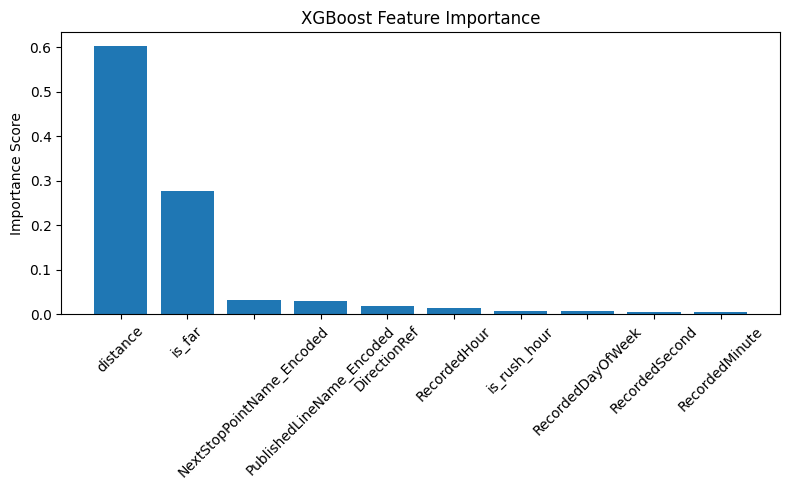

In [55]:
feature_names = [
    'RecordedHour', 'RecordedMinute','DirectionRef', 'RecordedSecond', 'RecordedDayOfWeek',
    'PublishedLineName_Encoded', 'NextStopPointName_Encoded',
    'is_weekend', 'is_rush_hour', 'distance', 'is_far'
]
import matplotlib.pyplot as plt
import numpy as np

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10  # Show top 10 features (change if you want more/less)

plt.figure(figsize=(8, 5))
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45)
plt.title("XGBoost Feature Importance")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [56]:
for i in indices[:top_n]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


distance: 0.6030
is_far: 0.2769
NextStopPointName_Encoded: 0.0316
PublishedLineName_Encoded: 0.0302
DirectionRef: 0.0177
RecordedHour: 0.0139
is_rush_hour: 0.0081
RecordedDayOfWeek: 0.0071
RecordedSecond: 0.0059
RecordedMinute: 0.0057


<Figure size 1000x500 with 0 Axes>

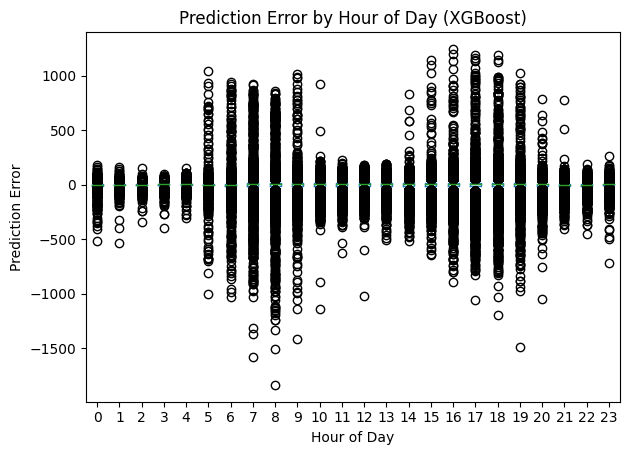

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose your test features DataFrame is X_test (DataFrame, not np.array!)
# and your actual and predicted values are y_test, y_pred_xgb

# 1. Calculate prediction errors
errors = y_pred_xgb - y_test

# 2. Make a DataFrame for analysis
df_analysis = pd.DataFrame(X_test, columns=features)
df_analysis['error'] = errors
df_analysis['RecordedHour'] = df_analysis['RecordedHour'].astype(int)  # ensure int for grouping

# 3. Create the boxplot
plt.figure(figsize=(10,5))
df_analysis.boxplot(column='error', by='RecordedHour', grid=False)
plt.xlabel('Hour of Day')
plt.ylabel('Prediction Error')
plt.title('Prediction Error by Hour of Day (XGBoost)')
plt.suptitle('')
plt.tight_layout()
plt.show()


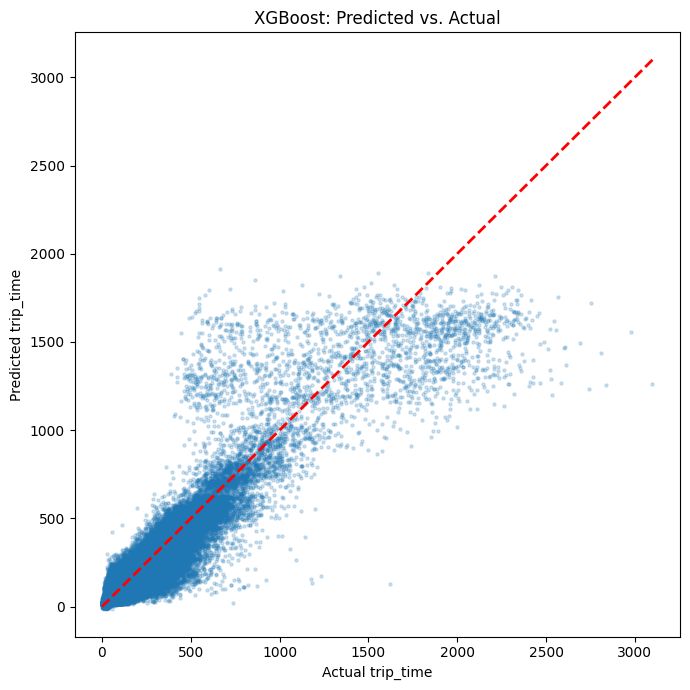

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_xgb, s=5, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual trip_time")
plt.ylabel("Predicted trip_time")
plt.title("XGBoost: Predicted vs. Actual")
plt.tight_layout()
plt.show()


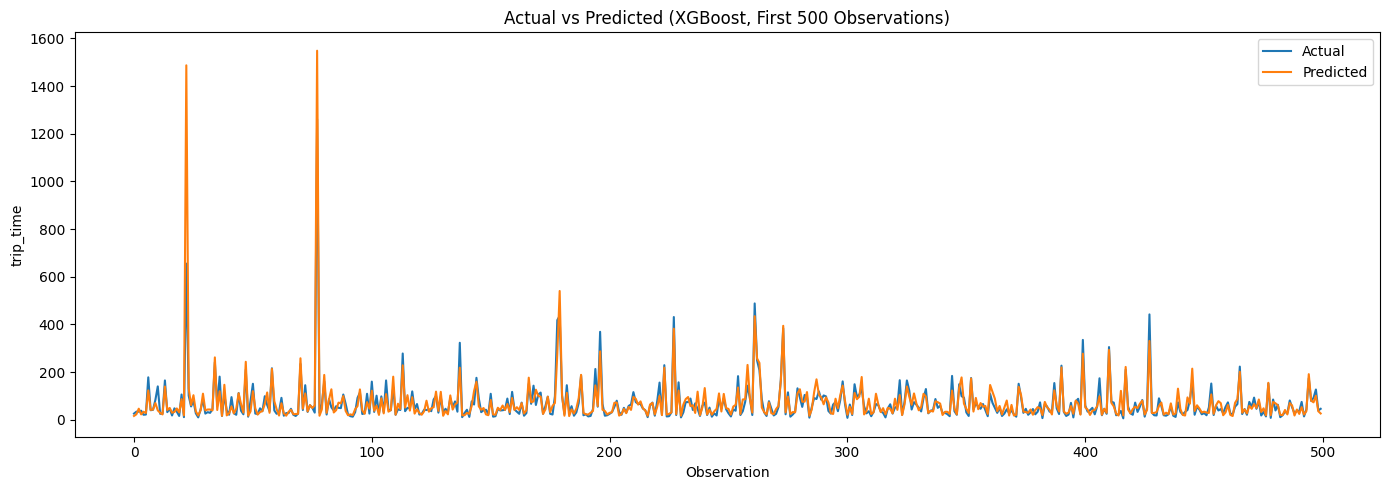

In [91]:
import matplotlib.pyplot as plt

N = 500  # Number of samples to plot for zoomed-in view
plt.figure(figsize=(14, 5))
plt.plot(y_test[:N], label='Actual')
plt.plot(y_pred_xgb[:N], label='Predicted')
plt.xlabel('Observation')
plt.ylabel('trip_time')
plt.title('Actual vs Predicted (XGBoost, First 500 Observations)')
plt.legend()
plt.tight_layout()
plt.show()


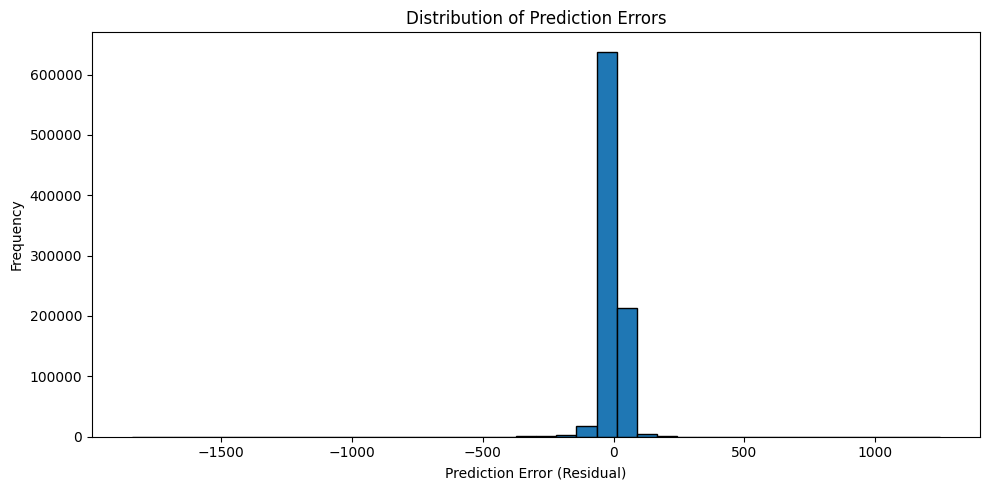

In [92]:
errors = y_pred_xgb - y_test  # use the model you want
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=40, edgecolor='black')
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()


In [60]:
import numpy as np

sample_size = 100_000
if len(train_df) > sample_size:
    train_sample = train_df.sample(n=sample_size, random_state=42)
else:
    train_sample = train_df.copy()
bool_cols = ['is_weekend', 'is_rush_hour', 'is_far']
train_sample[bool_cols] = train_sample[bool_cols].astype(int)
test_df[bool_cols] = test_df[bool_cols].astype(int)  # Ensure test data is int

features = [
     'RecordedHour', 'RecordedMinute','DirectionRef', 'RecordedSecond', 'RecordedDayOfWeek',
    'PublishedLineName_Encoded', 'NextStopPointName_Encoded',
    'is_weekend', 'is_rush_hour', 'distance', 'is_far'
]
target = 'trip_time'

X_train_rf = train_sample[features].values
y_train_rf = train_sample[target].values

X_test_rf = test_df[features].values
y_test_rf = test_df[target].values
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train_rf, y_train_rf)


RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [61]:
y_pred_rf = rf_model.predict(X_test_rf)

rmse_rf = mean_squared_error(y_test_rf, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

print(f"Random Forest 📉 RMSE: {rmse_rf:.4f}")
print(f"Random Forest 📉 MAE: {mae_rf:.4f}")
print(f"Random Forest 📈 R2: {r2_rf:.4f}")


Random Forest 📉 RMSE: 35.7682
Random Forest 📉 MAE: 20.3463
Random Forest 📈 R2: 0.8885


In [67]:
for i in indices[:top_n]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

distance: 0.8934
NextStopPointName_Encoded: 0.0654
PublishedLineName_Encoded: 0.0196
RecordedHour: 0.0108
DirectionRef: 0.0029
RecordedMinute: 0.0029
RecordedSecond: 0.0027
RecordedDayOfWeek: 0.0011
is_rush_hour: 0.0007
is_far: 0.0003


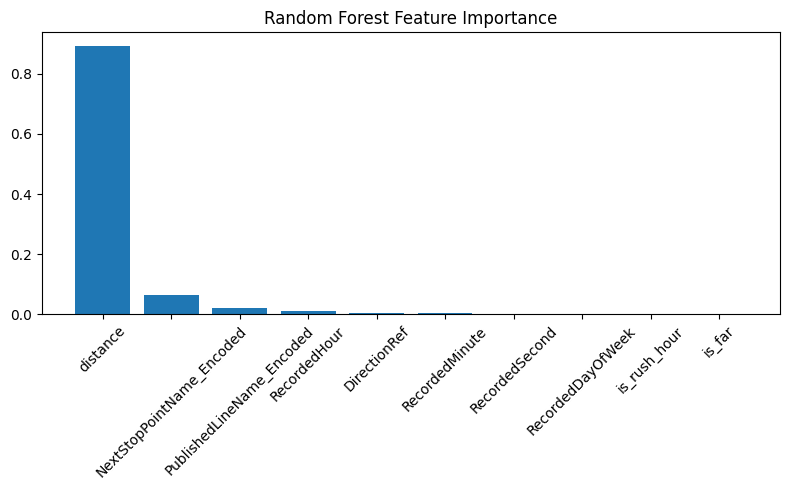

In [62]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]
feature_names = features
top_n = 10

plt.figure(figsize=(8, 5))
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 11
[LightGBM] [Info] Start training from score 74.823130
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 39.2728	valid_0's l2: 1542.35
LGBM 📉 RMSE: 39.0738
LGBM 📉 MAE: 19.9122
LGBM 📈 R2: 0.8670


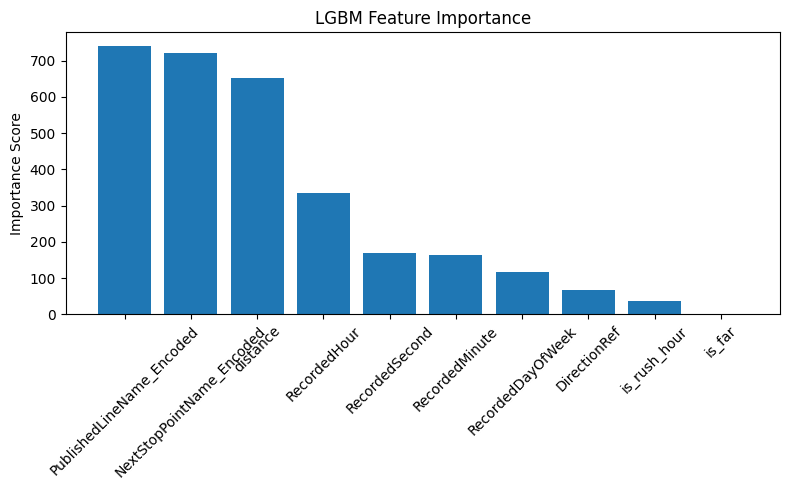

PublishedLineName_Encoded: 741
NextStopPointName_Encoded: 721
distance: 652
RecordedHour: 334
RecordedSecond: 168
RecordedMinute: 163
RecordedDayOfWeek: 116
DirectionRef: 67
is_rush_hour: 36
is_far: 2


In [74]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. Sample 100,000 rows from train_df
sample_size = 100_000
if len(train_df) > sample_size:
    train_sample = train_df.sample(n=sample_size, random_state=42)
else:
    train_sample = train_df.copy()

# 2. Prepare data
bool_cols = ['is_weekend', 'is_rush_hour', 'is_far']
for d in [train_sample, val_df, test_df]:
    d[bool_cols] = d[bool_cols].astype(int)


features = [
     'RecordedHour', 'RecordedMinute','DirectionRef', 'RecordedSecond', 'RecordedDayOfWeek',
    'PublishedLineName_Encoded', 'NextStopPointName_Encoded',
    'is_weekend', 'is_rush_hour', 'distance', 'is_far'
]
target = 'trip_time'

X_train = train_sample[features].values
y_train = train_sample[target].values
X_val = val_df[features].values
y_val = val_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values

# 3. Train LGBM with callback early stopping
lgbm_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(10)]
)


# 4. Evaluate
y_pred_lgbm = lgbm_model.predict(X_test)
rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LGBM 📉 RMSE: {rmse_lgbm:.4f}")
print(f"LGBM 📉 MAE: {mae_lgbm:.4f}")
print(f"LGBM 📈 R2: {r2_lgbm:.4f}")

# 5. Feature importance
importances = lgbm_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

plt.figure(figsize=(8, 5))
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), [features[i] for i in indices[:top_n]], rotation=45)
plt.title("LGBM Feature Importance")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

for i in indices[:top_n]:
    print(f"{features[i]}: {importances[i]}")


<Figure size 1000x500 with 0 Axes>

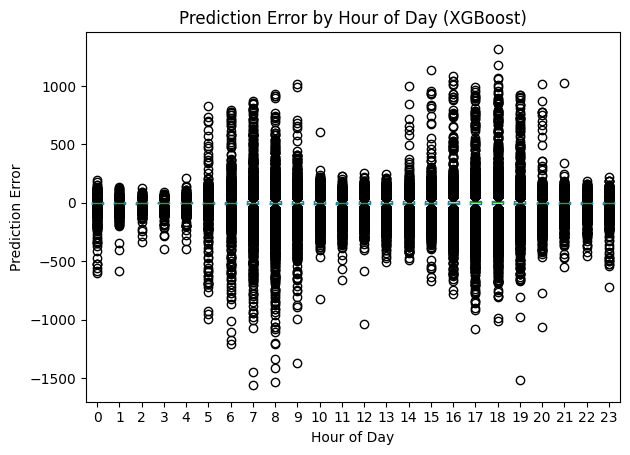

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose your test features DataFrame is X_test (DataFrame, not np.array!)
# and your actual and predicted values are y_test, y_pred_xgb

# 1. Calculate prediction errors
errors = y_pred_lgbm - y_test

# 2. Make a DataFrame for analysis
df_analysis = pd.DataFrame(X_test, columns=features)
df_analysis['error'] = errors
df_analysis['RecordedHour'] = df_analysis['RecordedHour'].astype(int)  # ensure int for grouping

# 3. Create the boxplot
plt.figure(figsize=(10,5))
df_analysis.boxplot(column='error', by='RecordedHour', grid=False)
plt.xlabel('Hour of Day')
plt.ylabel('Prediction Error')
plt.title('Prediction Error by Hour of Day (XGBoost)')
plt.suptitle('')
plt.tight_layout()
plt.show()


In [100]:
bool_cols = ['is_weekend', 'is_rush_hour', 'is_far']
for d in [train_df, val_df, test_df]:
    d[bool_cols] = d[bool_cols].astype(int)

features = [
     'RecordedHour', 'RecordedMinute','DirectionRef', 'RecordedSecond', 'RecordedDayOfWeek',
    'PublishedLineName_Encoded', 'NextStopPointName_Encoded',
    'is_weekend', 'is_rush_hour', 'distance', 'is_far'
]
target = 'trip_time'

X_train = train_df[features].values
y_train = train_df[target].values
X_val = val_df[features].values
y_val = val_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = {}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['LinearRegression'] = [
    mean_squared_error(y_test, y_pred_lr, squared=False),
    mean_absolute_error(y_test, y_pred_lr),
    r2_score(y_test, y_pred_lr)
]



In [101]:
print("Linear Regression Results:")
print(f"  RMSE: {results['LinearRegression'][0]:.4f}")
print(f"  MAE : {results['LinearRegression'][1]:.4f}")
print(f"  R2  : {results['LinearRegression'][2]:.4f}\n")

Linear Regression Results:
  RMSE: 48.0311
  MAE : 28.5330
  R2  : 0.7990



In [98]:
import numpy as np

print("Linear Regression Feature Importance (absolute coefficients):")
for f, coef in zip(features, lr.coef_):
    print(f"{f}: {coef:.4f}")


Linear Regression Feature Importance (absolute coefficients):
RecordedHour: 0.7082
RecordedMinute: -0.0011
DirectionRef: 0.0025
RecordedSecond: 0.0052
RecordedDayOfWeek: 0.1828
PublishedLineName_Encoded: -0.0771
NextStopPointName_Encoded: 0.2411
is_weekend: -8.3884
is_rush_hour: 7.7735
distance: 0.0630
is_far: 52.8335


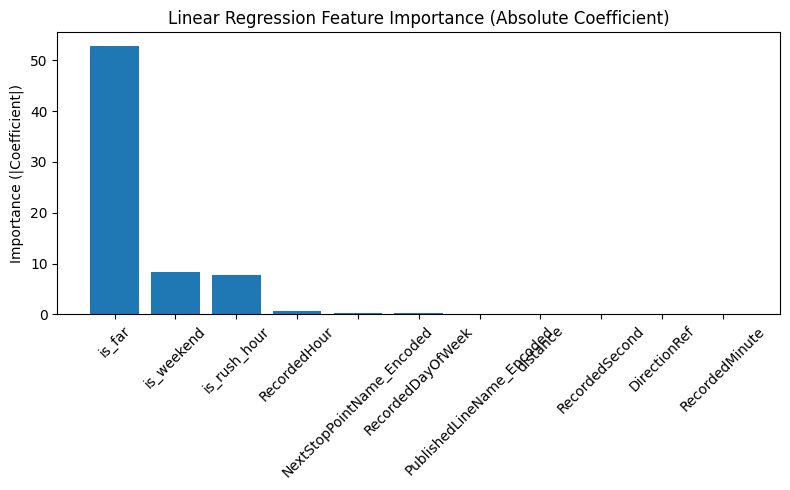

In [96]:
import matplotlib.pyplot as plt

# Linear Regression
coef_lr = np.abs(lr.coef_)
indices_lr = np.argsort(coef_lr)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(features)), coef_lr[indices_lr])
plt.xticks(range(len(features)), [features[i] for i in indices_lr], rotation=45)
plt.title('Linear Regression Feature Importance (Absolute Coefficient)')
plt.ylabel('Importance (|Coefficient|)')
plt.tight_layout()
plt.show()


